<a href="https://colab.research.google.com/github/BlancJH/Diffusion-Model-Handwritten-Digit-Generation/blob/main/diffusion_model_digit_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**0. Prepare Setting**

In [ ]:
# Import modules

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# Set seed to fix randomness

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
# Load dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
mnist = datasets.MNIST(root=".", train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


#**Unconditional Base Model**

##**1. Model Setting**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. UNet-like model setting

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(),
        )
        self.mid = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1),
        )

    def forward(self, x, t):
        # t is timestep embedding, but here we just ignore it for simplicity
        x = self.down1(x)
        x = self.down2(x)
        x = self.mid(x)
        x = self.up1(x)
        x = self.up2(x)
        return x

##**2. Diffusion Schedule Setting**

In [ ]:
T = 300  # number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

##**3. Forward Diffusion Setting**

In [ ]:
def forward_diffusion_sample(x0, t, device="cpu"):
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = get_index_from_list(torch.sqrt(alphas_cumprod), t, x0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1 - alphas_cumprod), t, x0.shape)
    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise, noise


##**4. Model Training**

In [ ]:
base_model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-4)

epochs = 30
for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        t = torch.randint(0, T, (imgs.shape[0],), device=device).long()
        x_t, noise = forward_diffusion_sample(imgs, t, device)
        noise_pred = base_model(x_t, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


Epoch 1/40 | Loss: 0.2736: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
Epoch 2/40 | Loss: 0.1861: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
Epoch 3/40 | Loss: 0.1256: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
Epoch 4/40 | Loss: 0.1467: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
Epoch 5/40 | Loss: 0.1072: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
Epoch 6/40 | Loss: 0.1025: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
Epoch 7/40 | Loss: 0.0994: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
Epoch 8/40 | Loss: 0.1077: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
Epoch 9/40 | Loss: 0.1015: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
Epoch 10/40 | Loss: 0.0871: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
Epoch 11/40 | Loss: 0.1090: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
Epoch 12/40 | Loss: 0.0946: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
Epoch 13/40 | Loss: 0.1038: 100%|██████████| 469/469 [00:13<00:00, 34.00i

##**5. Sampling**

In [ ]:
@torch.no_grad()
def sample(base_model, n=16):
    base_model.eval()
    x = torch.randn((n, 1, 28, 28)).to(device)
    for i in reversed(range(T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        betas_t = get_index_from_list(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1 - alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = get_index_from_list(torch.sqrt(1.0 / alphas), t, x.shape)

        base_model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * base_model(x, t))
        if i > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(betas_t)
            x = base_model_mean + sigma_t * noise
        else:
            x = base_model_mean
    x = (x.clamp(-1, 1) + 1) / 2
    return x

samples = sample(base_model, n=16).cpu()

##**6. Result**

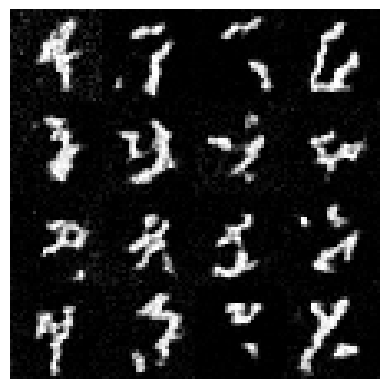

In [ ]:
grid = torch.cat([torch.cat([samples[i*4 + j] for j in range(4)], dim=2) for i in range(4)], dim=1)
plt.imshow(grid.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

#**Conditional Base Model (4, 8)**

##**1. Model Setting**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        # add time embedding (broadcast)
        time_emb = self.time_mlp(t_emb)[:, :, None, None]
        h = h + time_emb
        h = self.block2(h)
        return h + self.res_conv(x)


class ImprovedConditionalUNet(nn.Module):
    def __init__(self, num_classes=10, base_ch=128, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.label_emb = nn.Embedding(num_classes, time_emb_dim)

        # Encoder
        self.down1 = ResidualBlock(1, base_ch, time_emb_dim)
        self.down2 = ResidualBlock(base_ch, base_ch * 2, time_emb_dim)
        self.down3 = ResidualBlock(base_ch * 2, base_ch * 2, time_emb_dim)
        self.pool = nn.Conv2d(base_ch * 2, base_ch * 2, 4, 2, 1)

        # Bottleneck
        self.mid1 = ResidualBlock(base_ch * 2, base_ch * 4, time_emb_dim)
        self.mid2 = ResidualBlock(base_ch * 4, base_ch * 2, time_emb_dim)

        # Decoder
        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch * 2, 4, 2, 1)
        self.up_block1 = ResidualBlock(base_ch * 2, base_ch, time_emb_dim)
        self.skip2_proj = nn.Conv2d(base_ch * 2, base_ch, 1)
        self.up_block2 = ResidualBlock(base_ch, base_ch, time_emb_dim)
        self.final_conv = nn.Conv2d(base_ch, 1, 3, 1, 1)

    def forward(self, x, t, y):
        # Time embedding
        t_norm = t[:, None].float() / 1000  # normalize step
        t_emb = self.time_mlp(t_norm)

        # Label embedding
        label_emb = torch.zeros_like(t_emb)
        cond_mask = y != -1
        if cond_mask.any():
            label_emb[cond_mask] = self.label_emb(y[cond_mask])
        t_emb = t_emb + label_emb

        # Downsampling path
        x1 = self.down1(x, t_emb)
        x2 = self.down2(x1, t_emb)
        x3 = self.down3(x2, t_emb)
        pooled = self.pool(x3)

        # Bottleneck
        mid = self.mid1(pooled, t_emb)
        mid = self.mid2(mid, t_emb)

        # Upsampling path
        up = self.up1(mid)
        up = self.up_block1(up + x3, t_emb)
        x2_proj = self.skip2_proj(x2)
        up = self.up_block2(up + x2_proj, t_emb)
        out = self.final_conv(up)
        return out

##**2. Diffusion Schedule Setting**

In [ ]:
T = 300  # number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

##**3. Forward Diffusion Setting**

In [ ]:
def forward_diffusion_sample(x0, t, device="cpu"):
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = get_index_from_list(torch.sqrt(alphas_cumprod), t, x0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1 - alphas_cumprod), t, x0.shape)
    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise, noise


##**4. Model Training**

In [ ]:
conditional_base_model = ImprovedConditionalUNet().to(device)
optimizer = torch.optim.Adam(conditional_base_model.parameters(), lr=5e-5) # Increase lr as larger model have higher gradient

epochs = 30
for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for imgs, y in pbar:
        imgs, y = imgs.to(device), y.to(device)
        t = torch.randint(0, T, (imgs.shape[0],), device=device).long()
        x_t, noise = forward_diffusion_sample(imgs, t, device)
        drop_prob = 0.1
        mask = torch.rand_like(y.float()) < drop_prob
        y_cond = y.clone()
        y_cond[mask] = -1  # -1 indicates "no label"
        noise_pred = conditional_base_model(x_t, t, y_cond)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(conditional_base_model.parameters(), max_norm=1.0) # Prevent instability in early epochs
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


Epoch 1/30 | Loss: 0.0610: 100%|██████████| 469/469 [02:01<00:00,  3.85it/s]
Epoch 2/30 | Loss: 0.0490: 100%|██████████| 469/469 [02:02<00:00,  3.84it/s]
Epoch 3/30 | Loss: 0.0585: 100%|██████████| 469/469 [02:02<00:00,  3.83it/s]
Epoch 4/30 | Loss: 0.0407: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 5/30 | Loss: 0.0451: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 6/30 | Loss: 0.0413: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 7/30 | Loss: 0.0377: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 8/30 | Loss: 0.0440: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 9/30 | Loss: 0.0385: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 10/30 | Loss: 0.0412: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 11/30 | Loss: 0.0409: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 12/30 | Loss: 0.0457: 100%|██████████| 469/469 [02:02<00:00,  3.82it/s]
Epoch 13/30 | Loss: 0.0409: 100%|██████████| 469/469 [02:02<00:00,  3.82i

##**6. Sampling**

In [ ]:
@torch.no_grad()
def sample(conditional_base_model, n=16, label=4, guidance_scale=1.0):
    conditional_base_model.eval()
    x = torch.randn((n, 1, 28, 28)).to(device)
    y_cond = torch.full((n,), label, device=device, dtype=torch.long)
    y_uncond = torch.full((n,), -1, device=device, dtype=torch.long)

    for i in reversed(range(T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        betas_t = get_index_from_list(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1 - alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = get_index_from_list(torch.sqrt(1.0 / alphas), t, x.shape)

        eps_cond = conditional_base_model(x, t, y_cond)
        eps_uncond = conditional_base_model(x, t, y_uncond)
        eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        conditional_base_model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * eps)
        if i > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(betas_t)
            x = conditional_base_model_mean + sigma_t * noise
        else:
            x = conditional_base_model_mean

    x = (x.clamp(-1, 1) + 1) / 2
    return x


##**7. Result**


Guidance scale = 5 | Digit 0


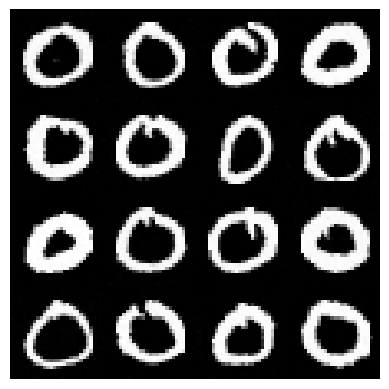


Guidance scale = 5 | Digit 1


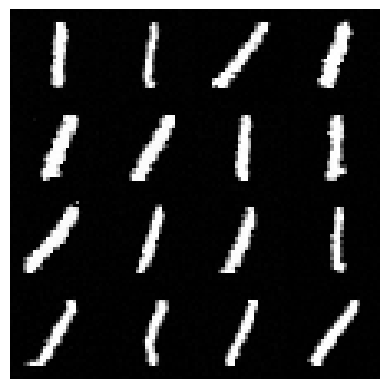


Guidance scale = 5 | Digit 2


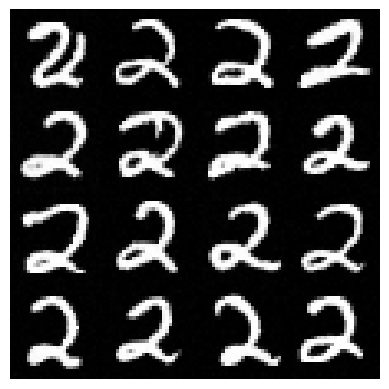


Guidance scale = 5 | Digit 3


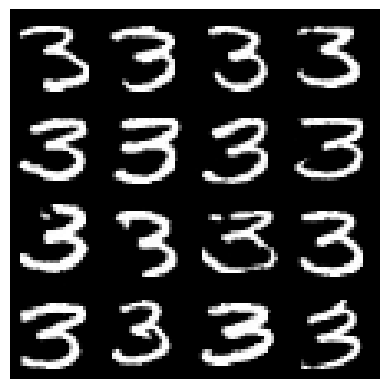


Guidance scale = 5 | Digit 4


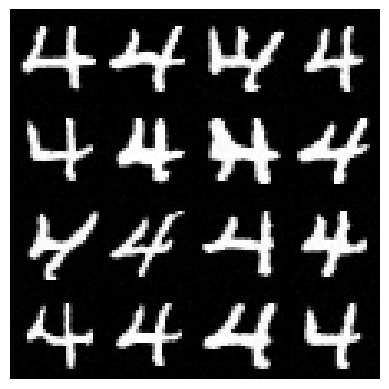


Guidance scale = 5 | Digit 5


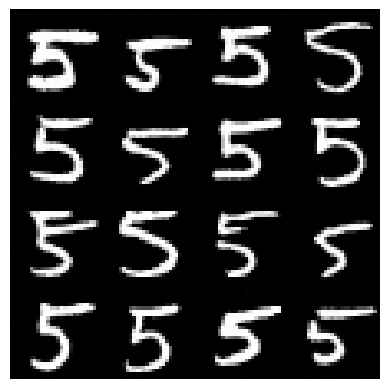


Guidance scale = 5 | Digit 6


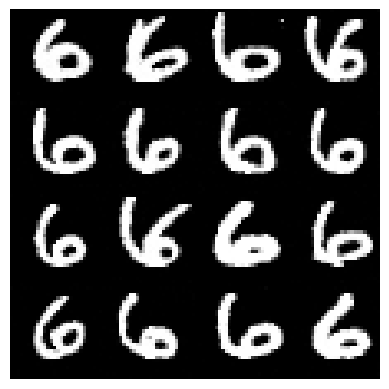


Guidance scale = 5 | Digit 7


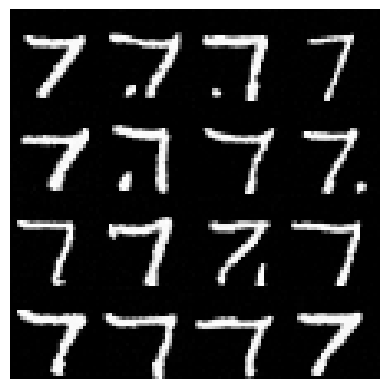


Guidance scale = 5 | Digit 8


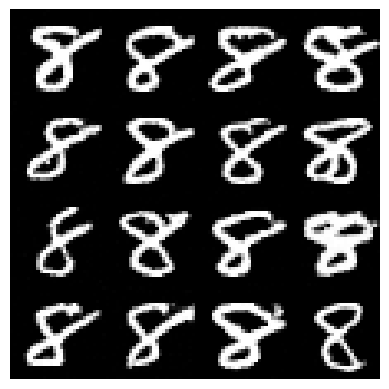


Guidance scale = 5 | Digit 9


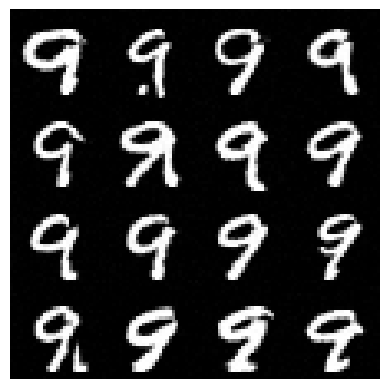

In [ ]:
def show_grid(samples):
    grid = torch.cat([torch.cat([samples[i*4 + j] for j in range(4)], dim=2) for i in range(4)], dim=1)
    plt.imshow(grid.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

guidance_levels = [5]
for g in guidance_levels:
    for digit in range(10):  # generate digits 0–9
        print(f"\nGuidance scale = {g} | Digit {digit}")
        samples = sample(conditional_base_model, n=16, label=digit, guidance_scale=g).cpu()
        show_grid(samples)